In [1]:
!pip3 install numpy matplotlib seaborn scikit-image scikit-learn mlxtend

# **1. Dataset Preparation**

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from mlxtend.data import loadlocal_mnist

In [3]:
data_images, data_labels = loadlocal_mnist(images_path='dataset/emnist-letters-train-images-idx3-ubyte',
                                            labels_path='dataset/emnist-letters-train-labels-idx1-ubyte')

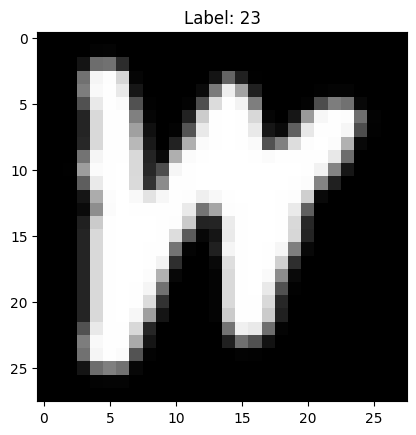

In [4]:
plt.imshow(data_images[0].reshape(28,28).T, cmap='gray')
plt.title(f"Label: {data_labels[0]}")
plt.show()

In [5]:
print("Jumlah gambar:", len(data_images))
print("Jumlah label :", len(data_labels))

Jumlah gambar: 124800
Jumlah label : 124800


In [6]:
data_labels = data_labels - 1

In [7]:
data_images = np.array(data_images)
data_labels = np.array(data_labels)

selected_images = []
selected_labels = []

for class_idx in range(26):
    idx = np.where(data_labels == class_idx)[0]
    if len(idx) >= 100:
        selected_idx = np.random.choice(idx, 100, replace=False)
        selected_images.append(data_images[selected_idx])
        selected_labels.append(data_labels[selected_idx])
    else:
        print(f"Kelas {class_idx} kosong, hanya ada {len(idx)} gambar.")

X_subset = np.vstack(selected_images)
y_subset = np.hstack(selected_labels)

print("Jumlah x_subset:", len(X_subset))
print("Jumlah y_subset :", len(y_subset))

Jumlah x_subset: 2600
Jumlah y_subset : 2600


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_subset, y_subset, test_size=0.2, random_state=42, stratify=y_subset
)

print("Jumlah x_train:", len(X_train))
print("Jumlah y_train :", len(y_train))
print("Jumlah x_test :", len(X_test))
print("Jumlah y_test :", len(y_test))

Jumlah x_train: 2080
Jumlah y_train : 2080
Jumlah x_test : 520
Jumlah y_test : 520


# **2. Feature Extraction**

In [9]:
feature, hog_img = hog(X_train[0].reshape(28,28), orientations=8, pixels_per_cell=(4, 4), cells_per_block=(2,2), visualize=True, block_norm='L2')

feature.shape

(1152,)

<BarContainer object of 1152 artists>

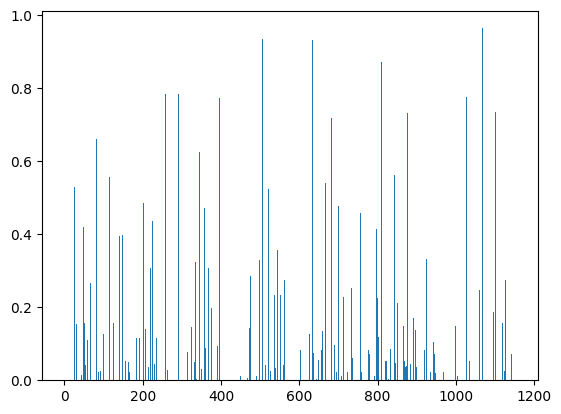

In [10]:
plt.bar(list(range(feature.shape[0])), feature)

In [11]:
def hog_features(images, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    features = []
    for image in images:
        feature = hog(image.reshape(28, 28), orientations=orientations,
                      pixels_per_cell=pixels_per_cell,
                      cells_per_block=cells_per_block,
                      block_norm='L2')
        features.append(feature)
    return np.array(features)

In [12]:
orientations = 8
pixels_per_cell = (4, 4)
cells_per_block = (2, 2)

In [13]:
X_train_hog = hog_features(X_train, orientations, pixels_per_cell, cells_per_block)
X_test_hog = hog_features(X_test, orientations, pixels_per_cell, cells_per_block)

In [14]:
print("X_train_hog shape:", X_train_hog.shape)
print("X_test_hog shape :", X_test_hog.shape)

X_train_hog shape: (2080, 1152)
X_test_hog shape : (520, 1152)


# **3. Classification**

In [15]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

In [16]:
svm = SVC()
grid_search = GridSearchCV(svm, param_grid, cv=2, n_jobs=-1, verbose=2)

In [17]:
grid_search.fit(X_train_hog, y_train)

Fitting 2 folds for each of 30 candidates, totalling 60 fits


[CV] END .................C=0.01, gamma=scale, kernel=linear; total time=   2.8s
[CV] END ..................C=0.01, gamma=auto, kernel=linear; total time=   3.1s
[CV] END ..................C=0.01, gamma=auto, kernel=linear; total time=   3.4s
[CV] END ...................C=0.01, gamma=scale, kernel=poly; total time=   4.0s
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time=   3.9s
[CV] END ....................C=0.01, gamma=auto, kernel=poly; total time=   4.0s
[CV] END ...................C=0.01, gamma=scale, kernel=poly; total time=   4.2s
[CV] END ....................C=0.01, gamma=auto, kernel=poly; total time=   4.5s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   2.1s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   2.7s
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=   5.3s
[CV] END .....................C=0.01, gamma=auto, kernel=rbf; total time=   5.5s
[CV] END ...................

GridSearchCV(cv=2, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']},
             verbose=2)

In [18]:
print("Best Parameters:", grid_search.best_params_)
print("Performance:", grid_search.best_estimator_.score(X_test_hog, y_test))

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Performance: 0.8288461538461539


In [19]:
best_model = grid_search.best_estimator_ 

# **4. Evaluation**

In [20]:
y_test_pred = best_model.predict(X_test_hog)

print("=== Test Set Evaluation ===")
print("Accuracy :", accuracy_score(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

=== Test Set Evaluation ===
Accuracy : 0.8288461538461539

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.90      0.82        20
           1       0.83      1.00      0.91        20
           2       0.89      0.85      0.87        20
           3       0.82      0.70      0.76        20
           4       0.74      0.85      0.79        20
           5       0.84      0.80      0.82        20
           6       0.77      0.50      0.61        20
           7       0.85      0.85      0.85        20
           8       0.67      0.70      0.68        20
           9       0.73      0.80      0.76        20
          10       1.00      0.90      0.95        20
          11       0.67      0.70      0.68        20
          12       1.00      0.80      0.89        20
          13       0.76      0.95      0.84        20
          14       0.86      0.95      0.90        20
          15       0.84      0.80      0.82        2

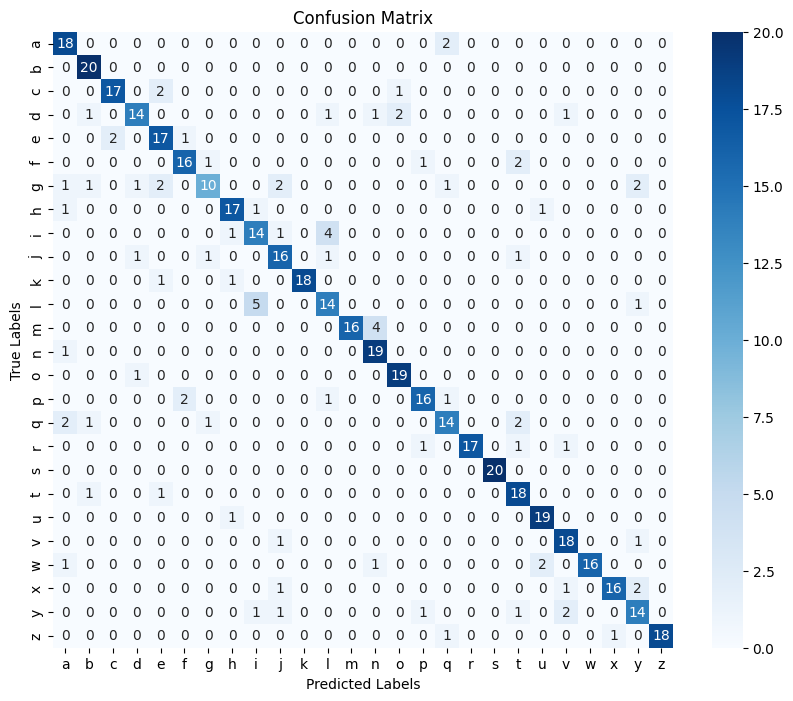

In [21]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[chr(i + 97) for i in range(26)], yticklabels=[chr(i + 97) for i in range(26)])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

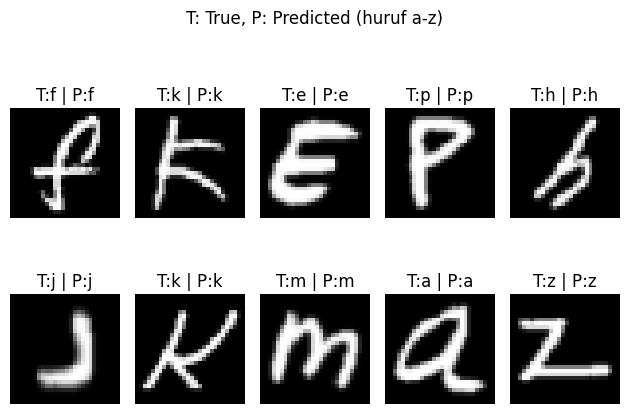

In [34]:
indices = random.sample(range(len(X_test)), 10)

for i, idx in enumerate(indices):
    img = X_test[idx].reshape(28, 28).T 
    true_label = y_test[idx] 
    pred_label = y_test_pred[idx] 

    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"T:{chr(true_label + 97)} | P:{chr(pred_label + 97)}") 
    plt.axis('off')

plt.suptitle("T: True, P: Predicted (huruf a-z)")
plt.tight_layout()
plt.show()